In [18]:
# Packages for model learning
import numpy as np
import sklearn.metrics
import pandas as pd
import sklearn.model_selection

import torch
import torchvision
import gpytorch
import botorch

# Packages for data loading
import json
from pathlib import Path

In [19]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

# set up gpax package 
# python setup.py install
from gpax.probing import probabilistic_probe

In [20]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

# Load and process data

In [21]:
# Make all photos square
def pad_image(img):
    h,w = img.shape[1:]
    if h != w:
        new_w = max(h,w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w+rem_w, pad_h+rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

In [22]:
#Load dataset

# img_root = './dataset/dress_pure_renamed/'
# train_metadata = json.loads(Path('./dataset/dress_pure_renamed/train.json').read_text())
# test_metadata = json.loads(Path('./dataset/dress_pure_renamed/test.json').read_text())
# val_metadata = json.loads(Path('./dataset/dress_pure_renamed/val.json').read_text())

# class_labels = ['christian_dior', 'maison_margiela']
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# img_root = Path('./dataset/')
# train_metadata = json.loads((img_root / 'train.json').read_text())
# test_metadata = json.loads((img_root / 'test.json').read_text())
# val_metadata = json.loads((img_root / 'val.json').read_text())
img_root = "F://datasets//fashion_designers_list//"
print(img_root)

train_metadata = json.loads(Path(img_root + '//train.json').read_text())
test_metadata = json.loads(Path(img_root + '//test.json').read_text())
val_metadata = json.loads(Path(img_root + '//val.json').read_text())

# class_labels = ["alexander_mcqueen","donatella_versace","karl_lagerfeld","yves_saint_laurent"]
class_labels = ["alexander_mcqueen", "donatella_versace", "john_galliano", "karl_lagerfeld", "yves_saint_laurent"]
class_labels = [x.replace('_',' ') for x in class_labels]
class_num = 5
image_size = 224

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)
n_all = n_train + n_test + n_val

all_classes = torch.empty(n_all, dtype=torch.int)
all_images = [None]*n_all
for i, meta in enumerate((*train_metadata, *test_metadata, *val_metadata)):
    if i%50==0:
        print(i)
    all_classes[i] = meta['label']
    all_images[i] = torchvision.io.read_image(str(Path(img_root + meta['file_path']))).to(device)
#     all_images[i] = pad_image(torchvision.transforms.functional.resize(all_images[i], image_size, antialias=True)) Dani
    all_images[i] = torchvision.transforms.functional.resize(pad_image(all_images[i]), image_size, antialias=True).to(device)

F://datasets//fashion_designers_list//
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700


In [23]:
n_classes = all_classes.max() + 1

In [24]:
from resnet_model import resnet_model

In [25]:
resnet_extractor = resnet_model(class_num,backbone="resnet18").to(device)
checkpoint = torch.load('results//fashion_designers_c5.3layer.bsz_128sz_224.sgd0.002//best_model.pt', map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [26]:
for p in resnet_extractor.parameters():
    p.requires_grad = False

In [27]:
# Define resnet feature extractor
resnet_input_transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms().to(device)
crop_size = resnet_input_transform.crop_size[0]
print(crop_size)

all_data = torch.empty(n_all, 3, crop_size, crop_size).to(device)
for i in range(n_all):
    all_data[i] = resnet_input_transform(all_images[i])

224


e:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [28]:
all_embeddings = resnet_extractor.backbone(all_data)

In [29]:
print(all_embeddings.shape)

torch.Size([2702, 512])


# tesing the renset

In [30]:
# train_embeddings_res = all_embeddings[0:n_train]
# testing_embeddings_res = all_embeddings[n_train:n_train+n_test]
# train_pre_res = torch.nn.functional.softmax(resnet_extractor.fc(train_embeddings_res),dim=1)
# testing_pre_res = torch.nn.functional.softmax(resnet_extractor.fc(testing_embeddings_res),dim=1)
# train_pre_res_class = torch.argmax(train_pre_res,dim=1)
# testing_pre_res_class = torch.argmax(testing_pre_res,dim=1)
# acc = sklearn.metrics.accuracy_score(all_classes[n_train:n_train+n_test], testing_pre_res_class.detach().cpu())
# auc = sklearn.metrics.roc_auc_score(all_classes[n_train:n_train+n_test],testing_pre_res.detach().cpu(),multi_class="ovo")
# print("resnet acc:{:.2f}".format(acc))
# print("resnet auc:{:.2f}".format(auc))


resnet acc:0.62
resnet auc:0.85


## use gpp() to measure the uncertainty of given query images.
gpp(
    x_query,
    x_observed=None,
    y_observed=None,
    alpha_eps=0.1,
    strength=5.0,
    n=int(1e5),
    seed=0,
)


    x_query: n' x d input array to be queried.
    x_observed: observed n x d input array. Set to None if no observations.
    y_observed: observed n x 1 evaluations on the input x_observed. Each element
      must be 0 or 1. Set to None if no observations.

In [31]:
from gpax.probing import probabilistic_probe

In [32]:
x_query = testing_embeddings_res.detach().cpu().numpy()
print(x_query.shape)
x_observed = train_embeddings_res.detach().cpu().numpy()
print(x_observed.shape)
y_observed = all_classes[0:n_train].detach().cpu().numpy().copy()
print(y_observed.shape)
print(y_observed)

(541, 512)
(1891, 512)
(1891,)
[4 4 1 ... 3 4 4]


## for each class, learn the concept and compute the probability and uncertainty
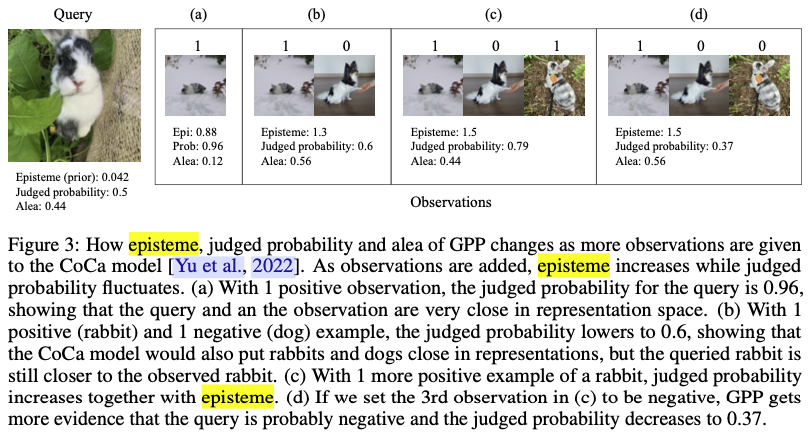
output:
Alea: (n'x1) Higher alea corresponds to more fuzziness in the label of a.

Episteme: (n'x1): Low episteme means we are “not sure” and high episteme that we are “highly confident” about the underlying probability. Alea, on the othe

Judged probability: prediction of testing image to be certain concept

bernoulli_mu:
epistemic_entropy:
epistemic_var:

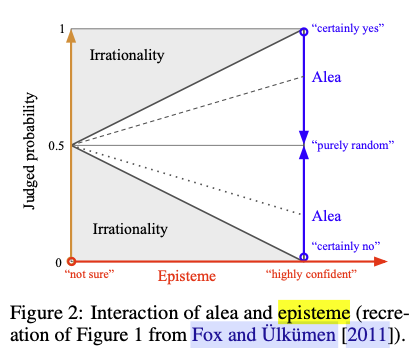


In [62]:
for current_class in range(0, n_classes):
    y_observed_current = np.zeros(y_observed.shape)
    y_observed_current[np.where(y_observed==current_class)]=1
    print(y_observed_current)

    # # gpp probing
    output = probabilistic_probe.gpp(x_query, x_observed, y_observed_current )
    print(output['Alea'])
    print(output['Judged probability'])
    print(output['Episteme'])

    # # GP regression for classification
    # output = probabilistic_probe.gpr(x_query, x_observed, y_observed_current )
    # print(output['Alea'])
    # print(output['Judged probability'])
    # print(output['Episteme'])


    # Linear probe ensemble using bootstrap
    # output = probabilistic_probe.lpe(x_query, x_observed, y_observed_current )
    # print(output['Alea'])
    # print(output['Judged probability'])
    # print(output['Episteme'])








[0. 0. 0. ... 0. 0. 0.]
[0.20987496 0.511946   0.08537354 0.00516013 0.01327867 0.02172264
 0.66625905 0.55380404 0.13105723 0.65271366 0.01821901 0.00497609
 0.31278506 0.04644377 0.56186515 0.11151753 0.6526628  0.03864529
 0.02348813 0.12104502 0.2751793  0.05662864 0.19927306 0.26815477
 0.18559831 0.2541237  0.5355193  0.04212828 0.07131394 0.01800223
 0.41597036 0.00511461 0.5178327  0.462168   0.06115759 0.37369055
 0.32204375 0.27088863 0.00763141 0.02702226 0.03358795 0.6507764
 0.12946375 0.5490246  0.45242578 0.18973933 0.05882201 0.26328245
 0.09661482 0.11307779 0.65693176 0.05189802 0.616347   0.66884285
 0.4203232  0.48909137 0.10578749 0.17695181 0.40400586 0.20949355
 0.25503033 0.11125629 0.30750558 0.17461775 0.04864283 0.62728214
 0.08466404 0.02691334 0.19512543 0.4922857  0.07011461 0.40147406
 0.12000977 0.01389659 0.03291897 0.05060092 0.5619931  0.5571364
 0.38492104 0.5605974  0.03282307 0.05066412 0.59785616 0.1989573
 0.34521046 0.01835644 0.07870418 0.67443

## Calculate the classification results of each class

In [ ]:
tensor_to_image = torchvision.transforms.ToPILImage()
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

## visualize the uncertainty of a designer (class)

current class:4
[0. 0. 0.]
[2.3918126]
[0.04142698]
[0.13258114]
current class:4
[0. 0. 1.]
[0.4558081]
[0.24338266]
[0.41726562]
current class:4
[0. 1. 1.]
[0.25562426]
[0.6932567]
[0.4613442]
current class:4
[1. 1. 1.]
[2.5763326]
[0.9656403]
[0.11678451]



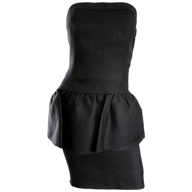
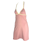
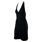
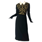
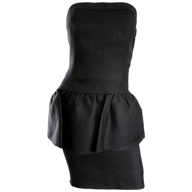
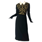
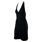
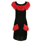
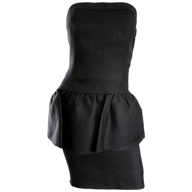
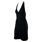
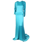
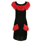
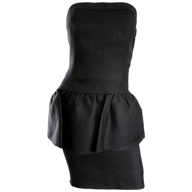
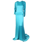
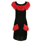
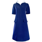

In [88]:
# prepare training sample images
import os

html_str = "<div style='display: flex;gap: 22px;flex-wrap: wrap;'>"
total_training_num = 3
idx = 100 #current query image idx in the testing dataset

# 5 sampels
pos_num = 0
for pos_num in range(0,total_training_num+1):
    pos_class_num = pos_num
    neg_class_num = total_training_num - pos_num

    x_query_sample = x_query[idx]
    current_class = test_metadata[idx]['label']

    print('current class:{}'.format(current_class))
    current_class_idxes = np.where(y_observed==current_class)[0]
    other_class_idxes = np.where(y_observed!=current_class)[0]
    current_class_idxes_train = current_class_idxes[0:pos_class_num]
    other_class_idxes_train = other_class_idxes[0:neg_class_num]
    trainning_class_idxes = np.concatenate((current_class_idxes_train, other_class_idxes_train), axis=0)
    np.random.shuffle(trainning_class_idxes)
    trainning_y = y_observed[trainning_class_idxes]
    trainning_x = x_observed[trainning_class_idxes]
    trainning_y_current = np.zeros(trainning_y.shape)
    trainning_y_current[np.where(trainning_y==current_class)]=1
    print(trainning_y_current)

        # # gpp probing
    output = probabilistic_probe.gpp(np.expand_dims(x_query[idx],axis=0), trainning_x, trainning_y_current )
    print(output['Episteme'])
    print(output['Judged probability'])
    print(output['Alea'])
    pos_num += 1

    # # GP regression for classification
    # output = probabilistic_probe.gpr(x_query, x_observed, y_observed_current )
    # print(output['Alea'])
    # print(output['Judged probability'])
    # print(output['Episteme'])


    # Linear probe ensemble using bootstrap
    # output = probabilistic_probe.lpe(x_query, x_observed, y_observed_current )
    # print(output['Alea'])
    # print(output['Judged probability'])
    # print(output['Episteme'])

    # visual the results
    x_query_sample_pth = test_metadata[idx]['file_path']
    query_img = torchvision.io.read_image(os.path.join(img_root,x_query_sample_pth))
    train_img_list = []
    train_img_class_list = []
    for train_img_idx in trainning_class_idxes:
        train_img_class_list.append(train_metadata[train_img_idx]['label'])
        train_img = torchvision.io.read_image(os.path.join(img_root,train_metadata[train_img_idx]['file_path']))
        train_img_list.append(train_img)
    
    top_5_figures = ''.join([
        fr"""<div class="img-box small-box" data-class="{5}"><img src="{tensor_to_url(train_img_list[ith], 42)}">{train_img_class_list[ith]}</div>"""
        for ith in range(0,len(train_img_list))])
    html_str += fr'''<div>
        <div style='margin: 0 auto; display: flex;'>
        <div class="img-box big-box border" style='border-right: 0 !important;'>
            <img src="{tensor_to_url(query_img, 192)}">
        </div>
        <div class="small-holder">{top_5_figures}</div>
        </div>
        <pre>
        Episteme: {100*output['Episteme'][0]:0.2f}%
        Probability: {100*output['Judged probability'][0]:0.2f}%
        Alea: {100*output['Alea'][0]:0.2f}%
        Class:  {current_class}</pre> 
    </div>'''
html_str += '</div>'
ipd.HTML(html_str)




visual